In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from pycountry_convert import country_alpha2_to_country_name, country_name_to_country_alpha3
import plotly.express as px
from plotly.offline import iplot

<h3>Questions</h3>
<p>- How the the views, likes, dislikes, and other statistics plotted overtime?</p>
<p>- What are the tags that trend on Indonesia?</p>
<p>- How long it usually took the video to blow up on trending page?</p>
<p>- What are the categories that people interested in?</p>

In [3]:
yt_ina = pd.read_csv('datasets/INA_youtube_trending_data.csv', low_memory=False)
yt_ina.head(2)

video_id          publish_time                channel_id  \
0      NaN  2021-02-05T09:00:34Z  UCEf_Bc-KVd7onSeifS3py9g   
1      NaN  2021-02-04T15:54:08Z  UCYEa4_MC7OFjcWrO6SO-u8g   

                                               title  \
0                        aespa 에스파 'Forever (약속)' MV   
1  [FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...   

                                         description thumbnail_url  \
0  aespa's new single "Forever" is out!\nListen a...           NaN   
1  Jakarta, https://www.tvonenews.com - Ketua umu...           NaN   

   thumbnail_width  thumbnail_height            channel_name  \
0              NaN               NaN                  SMTOWN   
1              NaN               NaN  Indonesia Lawyers Club   

                                                tags  ...  caption  \
0                                                NaN  ...     True   
1  ['tvone', 'tv one', 'tvonenews', 'indonesia la...  ...    False   

  license_status allowed_region blocked_region       view      like  dislike  \
0           True            NaN            NaN  7806846.0  857902.0  24078.0   
1           True            NaN            NaN   885038.0    6765.0   1263.0   

   favorite  comment                     trending_time  
0         0  94961.0  2021-02-07 05:46:51.832614+00:00  
1         0   6365.0  2021-02-07 05:46:51.832649+00:00  

[2 rows x 27 columns]

In [4]:
yt_ina.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128150 entries, 0 to 128149
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   video_id           75028 non-null   object 
 1   publish_time       128150 non-null  object 
 2   channel_id         128150 non-null  object 
 3   title              128150 non-null  object 
 4   description        123422 non-null  object 
 5   thumbnail_url      75028 non-null   object 
 6   thumbnail_width    75028 non-null   float64
 7   thumbnail_height   75028 non-null   float64
 8   channel_name       128150 non-null  object 
 9   tags               110710 non-null  object 
 10  category_id        128150 non-null  int64  
 11  live_status        128150 non-null  object 
 12  local_title        128150 non-null  object 
 13  local_description  123422 non-null  object 
 14  duration           128150 non-null  object 
 15  dimension          128150 non-null  object 
 16  de

<h2>Preprocess The Data</h2>
<p>- Drop unrelated columns</p>
<p>- Handling null values</p>
<p>- Change dtype</p>

In [5]:
#Drop unrelated columns
yt_ina = yt_ina[['publish_time', 'title', 'channel_name', 'view', 'like', 'dislike', 'comment', 'trending_time', 'tags', 'category_id', 'duration', 'allowed_region', 'blocked_region']]

#Handling null values
yt_ina.view.fillna(yt_ina.view.mean(), inplace=True)
yt_ina.dislike.fillna(yt_ina.dislike.mean(), inplace=True)
yt_ina.like.fillna(yt_ina.like.mean(), inplace=True) 
yt_ina.comment.fillna(yt_ina.comment.mean(), inplace=True)
yt_ina.tags.fillna('NoTags', inplace=True)

#change datatypes
yt_ina.publish_time = pd.to_datetime(yt_ina.publish_time, format='%Y-%m-%d %H:%M:%S')
yt_ina.trending_time = pd.to_datetime(yt_ina.trending_time, format='%Y-%m-%d %H:%M:%S')

def duration_clean(str_time):
    x = re.split(r'\D+', str_time)
    x = list(filter(None, x))

    if len(x) < 2 : x = dt.datetime.strptime('|'.join(x[::-1]), '%S')
    elif len(x) < 3 : x = dt.datetime.strptime('|'.join(x[::-1]), '%S|%M')
    elif len(x) < 4 : x = dt.datetime.strptime('|'.join(x[::-1]), '%S|%M|%H')
    else : x = dt.datetime.strptime('|'.join(x[::-1]), '%S|%M|%H|%d')
   
    return x
    
yt_ina.duration = yt_ina.duration.apply(func=duration_clean)
yt_ina.duration = yt_ina.duration.dt.time

def tags_clean(tags):
    tags = tags[1:-1].split("', '")
    for tag in tags:
        tag = re.sub(r'\W+', '', tag)
    return ", ".join(tags)

yt_ina.tags = yt_ina.tags.apply(func=tags_clean)

category = pd.read_json('datasets/INA_category_id.json')
category = category['items']

#make a new dataframe that correspond to category on json files
genre_id= []
genre = []

for i in range(0, len(category)-1):
    genre_id.append(str(category[i]).split(", ")[2].split(': ')[-1].strip("'"))
    genre.append(str(category[i]).split(", ")[3].split(': ')[-1].strip("'"))

genre = pd.DataFrame(list(zip(genre_id, genre)), columns=['id', 'genre']).set_index('id')
yt_ina['category'] = yt_ina['category_id'].apply(lambda x : genre.loc[str(x)]['genre'] if x != 29 else "Nonprofits & Activism")

yt_ina.drop('category_id', axis=1)

#Drop unrelated columns
yt_ina = yt_ina[['publish_time', 'trending_time', 'title', 'channel_name', 'category', 'view', 'like', 'dislike', 'comment', 'tags', 'duration', 'allowed_region', 'blocked_region']]

#add duration in minute columns
durations = []
for i in yt_ina.duration:
    durations.append(i.hour*60 + i.minute + i.second/60)
yt_ina['duration_minute'] = durations

<h3>Analyze </h3>

- Plot published time and trend time
- Popular tags
- Popular channel
- View, like, dislike, comment, ratio
- Popular category

In [6]:
yt_ina.head(2)

publish_time                    trending_time  \
0 2021-02-05 09:00:34+00:00 2021-02-07 05:46:51.832614+00:00   
1 2021-02-04 15:54:08+00:00 2021-02-07 05:46:51.832649+00:00   

                                               title            channel_name  \
0                        aespa 에스파 'Forever (약속)' MV                  SMTOWN   
1  [FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...  Indonesia Lawyers Club   

          category       view      like  dislike  comment  \
0            Music  7806846.0  857902.0  24078.0  94961.0   
1  News & Politics   885038.0    6765.0   1263.0   6365.0   

                                                tags  duration allowed_region  \
0                                               oTag  00:05:07            NaN   
1  'tvone, tv one, tvonenews, indonesia lawyers c...  00:42:30            NaN   

  blocked_region  duration_minute  
0            NaN         5.116667  
1            NaN        42.500000

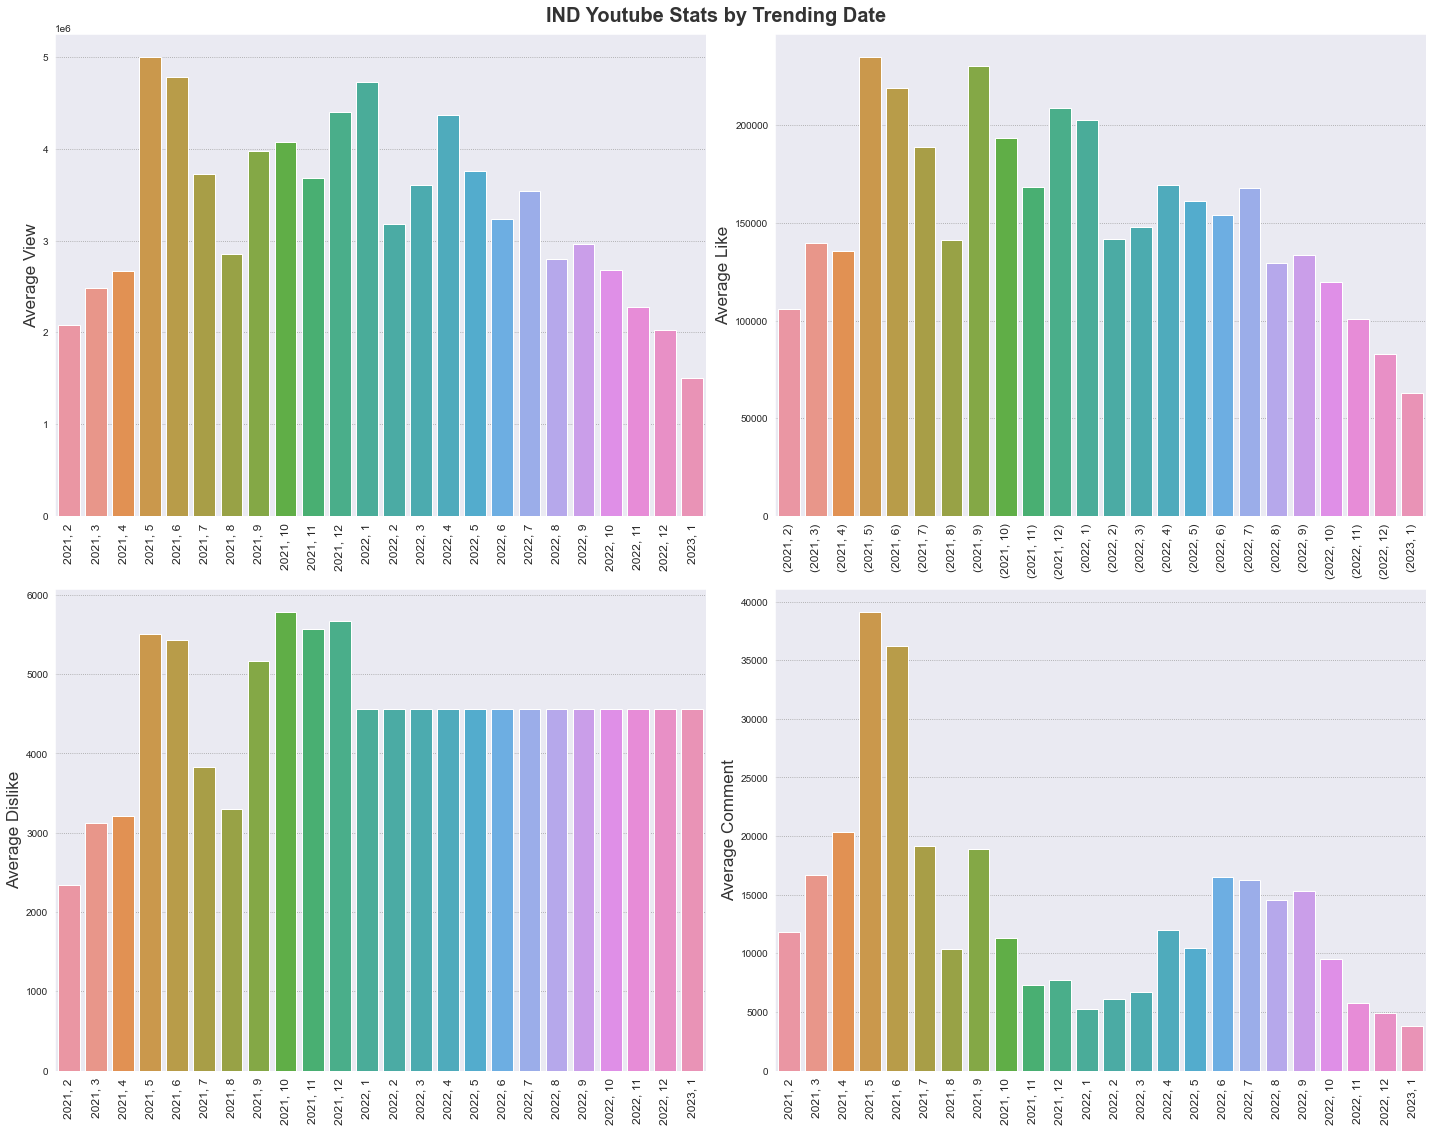

In [7]:
yt_ina_trend_monthstat = yt_ina.groupby(yt_ina.trending_time).mean().groupby(lambda x : (x.year, x.month)).mean()
date = []
for i in yt_ina_trend_monthstat.index:
    date.append(str(i).split(', ')[0].strip('(') + ", " + str(i).split(', ')[1].strip(')'))
yt_ina_trend_monthstat['date'] = date    

plt.rcParams["figure.figsize"] = [20, 16]
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, axes = plt.subplots(2, 2)

a = sns.barplot(data = yt_ina_trend_monthstat, x = 'date', y = 'view', ax=axes[0,0])
for tick in a.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
a.set_ylabel(ylabel = 'Average View', fontsize = 17, color='#333333')
a.set(xlabel=None)

b = sns.barplot(data = yt_ina_trend_monthstat, x = yt_ina_trend_monthstat.index , y = 'like', ax=axes[0,1])
for tick in b.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
b.set_ylabel(ylabel = 'Average Like', fontsize = 17, color='#333333')
b.set(xlabel=None)

c = sns.barplot(data = yt_ina_trend_monthstat, x = 'date', y = 'dislike', ax=axes[1,0])
for tick in c.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
c.set_ylabel(ylabel = 'Average Dislike', fontsize = 17, color='#333333')
c.set(xlabel=None)

d = sns.barplot(data = yt_ina_trend_monthstat, x = 'date', y = 'comment', ax=axes[1,1])
for tick in d.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
d.set_ylabel(ylabel = 'Average Comment', fontsize = 17, color='#333333')
d.set(xlabel=None)

fig.suptitle("IND Youtube Stats by Trending Date", fontsize=20, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

In [21]:
yt_ina_trend_monthstat

view           like      dislike       comment  \
(2021, 2)   2.079809e+06  105971.814718  2343.891141  11850.285763   
(2021, 3)   2.485023e+06  139552.679389  3127.690908  16682.808752   
(2021, 4)   2.672210e+06  135798.040626  3212.138669  20356.788587   
(2021, 5)   4.999857e+06  234954.939196  5506.353371  39125.220338   
(2021, 6)   4.785789e+06  219152.871524  5433.290824  36206.987555   
(2021, 7)   3.722639e+06  188753.848673  3832.453708  19123.377878   
(2021, 8)   2.853157e+06  141132.394791  3295.871437  10333.571257   
(2021, 9)   3.977319e+06  230215.205846  5160.397735  18913.019856   
(2021, 10)  4.075891e+06  193502.901556  5786.379703  11308.726427   
(2021, 11)  3.677708e+06  168209.296808  5570.610911   7277.560005   
(2021, 12)  4.397149e+06  208745.255980  5671.287892   7753.605529   
(2022, 1)   4.733643e+06  202587.917254  4561.291535   5285.925658   
(2022, 2)   3.183890e+06  141704.028721  4561.291535   6134.623918   
(2022, 3)   3.601584e+06  148058.743537  4561.291535   6689.575224   
(2022, 4)   4.371999e+06  169546.433739  4561.291535  11978.012447   
(2022, 5)   3.755755e+06  161093.407926  4561.291535  10421.971623   
(2022, 6)   3.231705e+06  154256.833210  4561.291535  16555.695618   
(2022, 7)   3.539901e+06  168186.993192  4561.291535  16240.114200   
(2022, 8)   2.795755e+06  129432.990725  4561.291535  14521.977547   
(2022, 9)   2.960085e+06  133398.589179  4561.291535  15296.607623   
(2022, 10)  2.683988e+06  119975.969320  4561.291535   9563.252746   
(2022, 11)  2.279148e+06  100903.556155  4561.291535   5791.246399   
(2022, 12)  2.029318e+06   82790.638610  4561.291535   4951.318833   
(2023, 1)   1.503417e+06   63208.736606  4561.291535   3820.179316   

            duration_minute      date  
(2021, 2)         20.002408   2021, 2  
(2021, 3)         14.317716   2021, 3  
(2021, 4)         17.622928   2021, 4  
(2021, 5)         13.815863   2021, 5  
(2021, 6)         22.083608   2021, 6  
(2021, 7)         16.745282   2021, 7  
(2021, 8)         16.224987   2021, 8  
(2021, 9)         19.855917   2021, 9  
(2021, 10)        26.820823  2021, 10  
(2021, 11)        22.284486  2021, 11  
(2021, 12)        19.976085  2021, 12  
(2022, 1)         23.195462   2022, 1  
(2022, 2)         16.165766   2022, 2  
(2022, 3)         22.046312   2022, 3  
(2022, 4)         13.350093   2022, 4  
(2022, 5)         14.942905   2022, 5  
(2022, 6)         15.502884   2022, 6  
(2022, 7)         15.642506   2022, 7  
(2022, 8)         13.665274   2022, 8  
(2022, 9)         14.029181   2022, 9  
(2022, 10)        12.989048  2022, 10  
(2022, 11)        15.815694  2022, 11  
(2022, 12)        17.497067  2022, 12  
(2023, 1)         14.993884   2023, 1

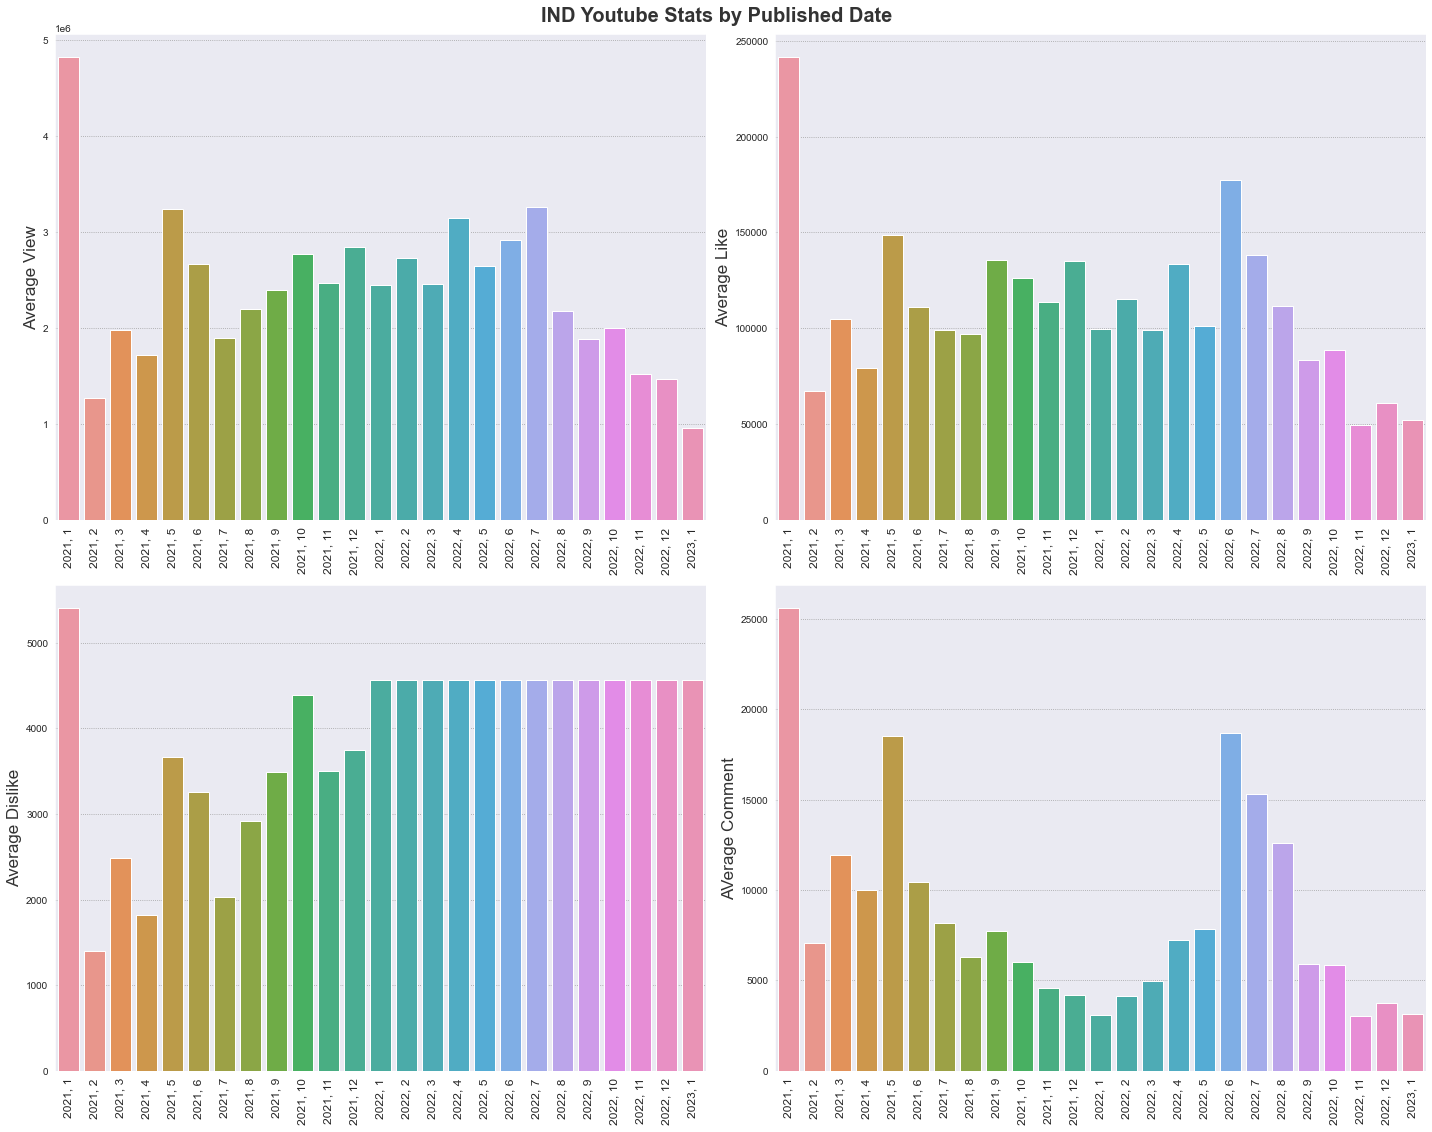

In [8]:
yt_ina_published_monthstat = yt_ina.groupby(yt_ina.publish_time).mean().groupby(lambda x : (x.year, x.month)).mean()
date = []
for i in yt_ina_published_monthstat.index:
    date.append(str(i).split(', ')[0].strip('(') + ", " + str(i).split(', ')[1].strip(')'))
yt_ina_published_monthstat['date'] = date    

plt.rcParams["figure.figsize"] = [20, 16]
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, axes = plt.subplots(2, 2)

a = sns.barplot(data = yt_ina_published_monthstat, x = 'date', y = 'view', ax=axes[0,0])
for tick in a.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
a.set_ylabel(ylabel = 'Average View', fontsize = 17, color='#333333')
a.set(xlabel=None)

b = sns.barplot(data = yt_ina_published_monthstat, x = 'date', y = 'like', ax=axes[0,1])
for tick in b.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
b.set_ylabel(ylabel = 'Average Like', fontsize = 17, color='#333333')
b.set(xlabel=None)

c = sns.barplot(data = yt_ina_published_monthstat, x = 'date', y = 'dislike', ax=axes[1,0])
for tick in c.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
c.set_ylabel(ylabel = 'Average Dislike', fontsize = 17, color='#333333')
c.set(xlabel=None)

d = sns.barplot(data = yt_ina_published_monthstat, x = 'date', y = 'comment', ax=axes[1,1])
for tick in d.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
d.set_ylabel(ylabel = 'AVerage Comment', fontsize = 17, color='#333333')
d.set(xlabel=None)

fig.suptitle("IND Youtube Stats by Published Date", fontsize=20, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

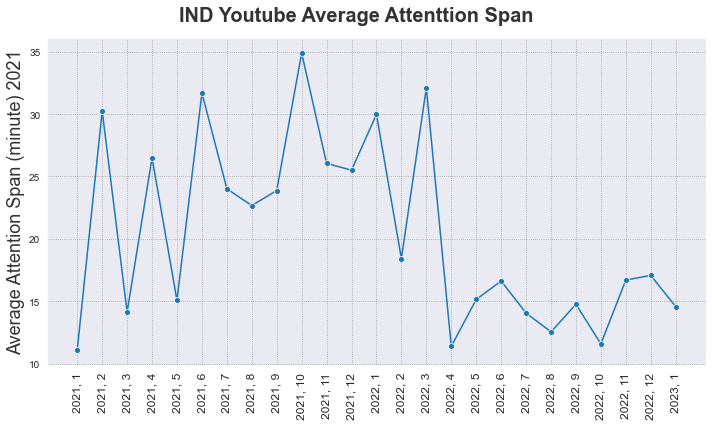

In [9]:
yt_ina_attention = yt_ina.groupby(yt_ina.publish_time).mean().groupby(lambda x : (x.year, x.month)).mean()
date = []
for i in yt_ina_attention.index:
    date.append(str(i).split(', ')[0].strip('(') + ", " + str(i).split(', ')[1].strip(')'))
yt_ina_attention['date'] = date   

plt.rcParams["figure.figsize"] = [10, 6]
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, axes = plt.subplots()

a = sns.lineplot(data = yt_ina_attention, x = 'date', y = 'duration_minute', marker='o')
for tick in a.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)
a.set_ylabel(ylabel = 'Average Attention Span (minute) 2021', fontsize = 18, color='#333333')
a.set(xlabel=None)

fig.suptitle("IND Youtube Average Attenttion Span", fontsize=20, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

In [10]:
yt_ina_2021 = yt_ina[yt_ina.trending_time.dt.year == 2021]
yt_ina_2022 = yt_ina[yt_ina.trending_time.dt.year == 2022]

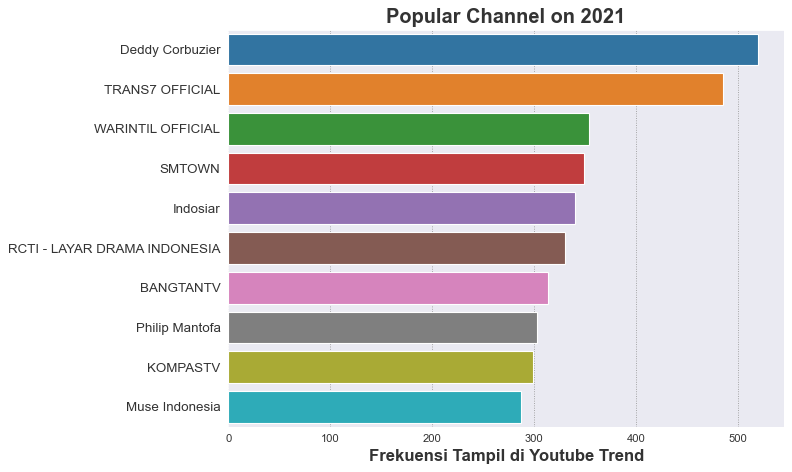

In [11]:
yt_ina_channel_2021 = pd.DataFrame(yt_ina[yt_ina.trending_time.dt.year == 2021]['channel_name'].value_counts().head(10))

plt.figure(figsize=(10, 6), dpi=80)
a = sns.barplot(data=yt_ina_channel_2021, y=yt_ina_channel_2021.index, x='channel_name')
a.set_xlabel('Frekuensi Tampil di Youtube Trend', fontsize=15, fontweight='bold', color='#333333')
for tick in a.get_xticklabels():
    tick.set_fontsize(10)
    tick.set_color('#333333')
for tick in a.get_yticklabels():
    tick.set_fontsize(12)
    tick.set_color('#333333')
plt.title('Popular Channel on 2021', fontsize=18, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

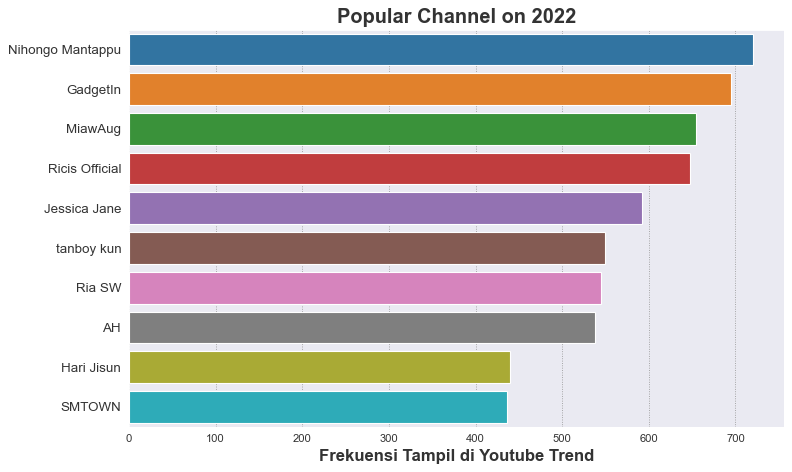

In [12]:
yt_ina_channel_2022 = pd.DataFrame(yt_ina[yt_ina.trending_time.dt.year == 2022]['channel_name'].value_counts().head(10))

plt.figure(figsize=(10, 6), dpi=80)
a = sns.barplot(data=yt_ina_channel_2022, y=yt_ina_channel_2022.index, x='channel_name')
a.set_xlabel('Frekuensi Tampil di Youtube Trend', fontsize=15, fontweight='bold', color='#333333')
for tick in a.get_xticklabels():
    tick.set_fontsize(10)
    tick.set_color('#333333')
for tick in a.get_yticklabels():
    tick.set_fontsize(12)
    tick.set_color('#333333')
plt.title('Popular Channel on 2022', fontsize=18, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

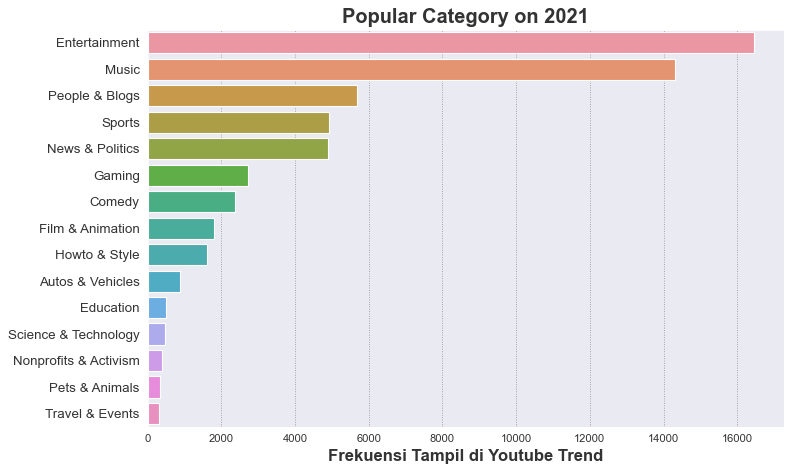

In [13]:
yt_ina_category_2021 = pd.DataFrame(yt_ina[yt_ina.trending_time.dt.year == 2021]['category'].value_counts())

plt.figure(figsize=(10, 6), dpi=80)
a = sns.barplot(data=yt_ina_category_2021, y=yt_ina_category_2021.index, x='category')
a.set_xlabel('Frekuensi Tampil di Youtube Trend', fontsize=15, fontweight='bold', color='#333333')
for tick in a.get_xticklabels():
    tick.set_fontsize(10)
    tick.set_color('#333333')
for tick in a.get_yticklabels():
    tick.set_fontsize(12)
    tick.set_color('#333333')
plt.title('Popular Category on 2021', fontsize=18, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

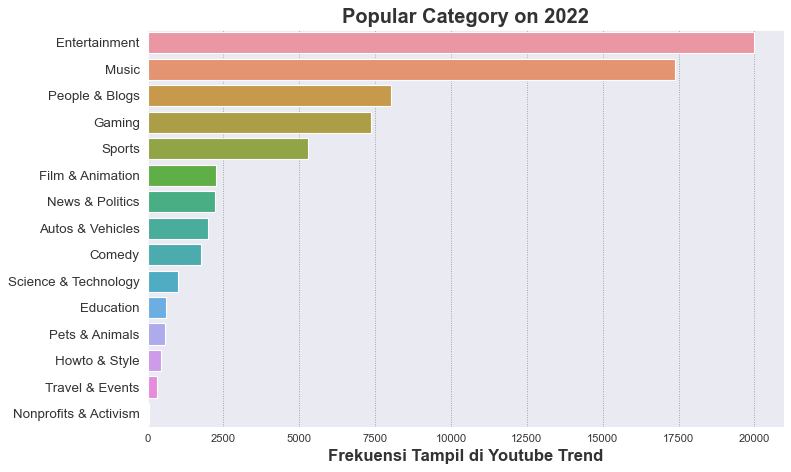

In [14]:
yt_ina_category_2022 = pd.DataFrame(yt_ina[yt_ina.trending_time.dt.year == 2022]['category'].value_counts())

plt.figure(figsize=(10, 6), dpi=80)
a = sns.barplot(data=yt_ina_category_2022, y=yt_ina_category_2022.index, x='category')
a.set_xlabel('Frekuensi Tampil di Youtube Trend', fontsize=15, fontweight='bold', color='#333333')
for tick in a.get_xticklabels():
    tick.set_fontsize(10)
    tick.set_color('#333333')
for tick in a.get_yticklabels():
    tick.set_fontsize(12)
    tick.set_color('#333333')
plt.title('Popular Category on 2022', fontsize=18, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

C:\Users\HP G7\AppData\Local\Temp\ipykernel_15240\855936299.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\HP G7\AppData\Local\Temp\ipykernel_15240\855936299.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 1600x1280 with 0 Axes>

c:\Users\HP G7\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



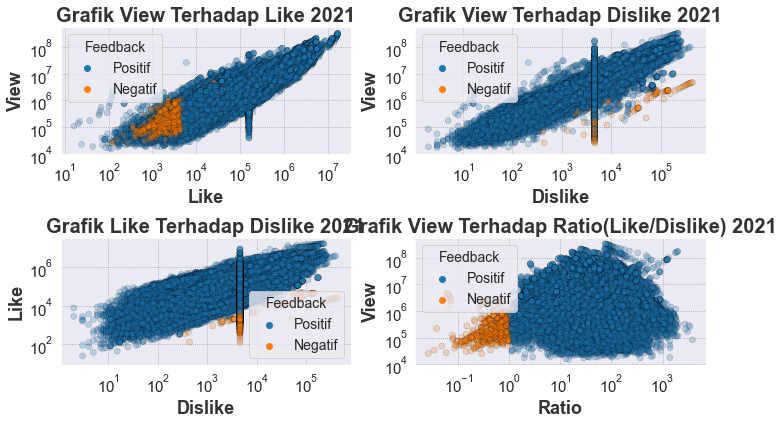

In [15]:
plt.figure(figsize=(20, 16), dpi=80)
yt_ina_2021['ratio'] = yt_ina_2021['like']/yt_ina_2021['dislike']
yt_ina_2021['feedback'] = yt_ina_2021['ratio'].apply(lambda x : 'Positif' if x >= 1.0 else 'Negatif')
fig, ax = plt.subplots(2,2)

a = sns.scatterplot(data=yt_ina_2021, x='like', y='view', edgecolor='black', alpha=.25, hue='feedback', ax=ax[0,0])
a.set(xscale='log', yscale='log')
a.set_xlabel('Like', fontsize=18., fontweight='bold', color='#333333')
a.set_ylabel('View', fontsize=18, fontweight='bold', color='#333333')
a.set_title('Grafik View Terhadap Like 2021', fontsize=20, fontweight='bold', color='#333333')
a.legend(title='Feedback', fontsize=14,  title_fontsize='14')
for tick in a.get_xticklabels():
    tick.set_fontsize(15)
for tick in a.get_yticklabels():
    tick.set_fontsize(15)

a = sns.scatterplot(data=yt_ina_2021, x='dislike', y='view', edgecolor='black', alpha=.25, hue='feedback', ax=ax[0,1])
a.set(xscale='log', yscale='log')
a.set_xlabel('Dislike', fontsize=18., fontweight='bold', color='#333333')
a.set_ylabel('View', fontsize=18, fontweight='bold', color='#333333')
a.set_title('Grafik View Terhadap Dislike 2021', fontsize=20, fontweight='bold', color='#333333')
a.legend(title='Feedback', fontsize=14,  title_fontsize='14')
for tick in a.get_xticklabels():
    tick.set_fontsize(15)
for tick in a.get_yticklabels():
    tick.set_fontsize(15)

a = sns.scatterplot(data=yt_ina_2021, x='dislike', y='like', edgecolor='black', alpha=.25, hue='feedback', ax=ax[1,0])
a.set(xscale='log', yscale='log')
a.set_xlabel('Dislike', fontsize=18., fontweight='bold', color='#333333')
a.set_ylabel('Like', fontsize=18, fontweight='bold', color='#333333')
a.set_title('Grafik Like Terhadap Dislike 2021', fontsize=20, fontweight='bold', color='#333333')
a.legend(title='Feedback', fontsize=14,  title_fontsize='14')
for tick in a.get_xticklabels():
    tick.set_fontsize(15)
for tick in a.get_yticklabels():
    tick.set_fontsize(15)

a = sns.scatterplot(data=yt_ina_2021, x='ratio', y='view', edgecolor='black', alpha=.25, hue='feedback', ax=ax[1,1])
a.set(xscale='log', yscale='log')
a.set_xlabel('Ratio', fontsize=18., fontweight='bold', color='#333333')
a.set_ylabel('View', fontsize=18, fontweight='bold', color='#333333')
a.set_title('Grafik View Terhadap Ratio(Like/Dislike) 2021', fontsize=20, fontweight='bold', color='#333333')
a.legend(title='Feedback', fontsize=14,  title_fontsize='14')
for tick in a.get_xticklabels():
    tick.set_fontsize(15)
for tick in a.get_yticklabels():
    tick.set_fontsize(15)

plt.tight_layout()
plt.show()

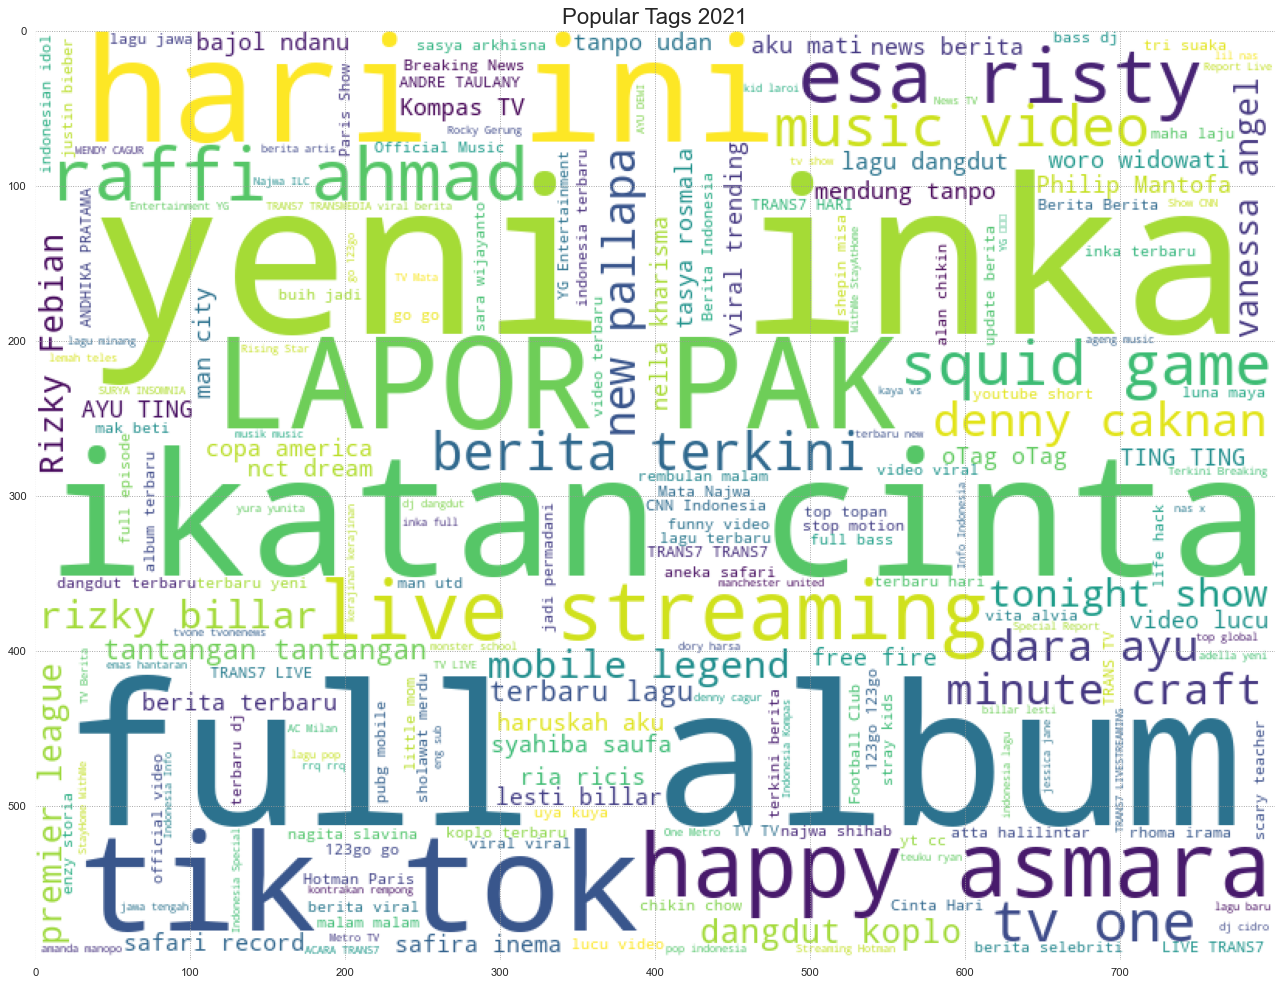

In [16]:
plt.figure(figsize=(20,16), dpi=80)
yt_ina_2021_tags = []

for i in yt_ina_2021['tags']:
    for j in str(i).split(', '):
        yt_ina_2021_tags.append(j)
tags_2021 = ' '.join(yt_ina_2021_tags)

wc2021 = WordCloud(background_color='white', width=800, height=600).generate(tags_2021)

plt.title('Popular Tags 2021', fontsize=20)
plt.imshow(wc2021)

In [17]:
plt.figure(figsize=(20,16), dpi=80)
yt_ina_2022_tags = []

for i in yt_ina_2022['tags']:
    for j in str(i).split(', '):
        yt_ina_2022_tags.append(j)
tags_2022 = ' '.join(yt_ina_2022_tags)

wc2022 = WordCloud(background_color='white', width=800, height=600).generate(tags_2022)

plt.title('Popular Tags 2022', fontsize=20)
plt.imshow(wc2022)

KeyboardInterrupt: 

<Figure size 1600x1280 with 0 Axes>

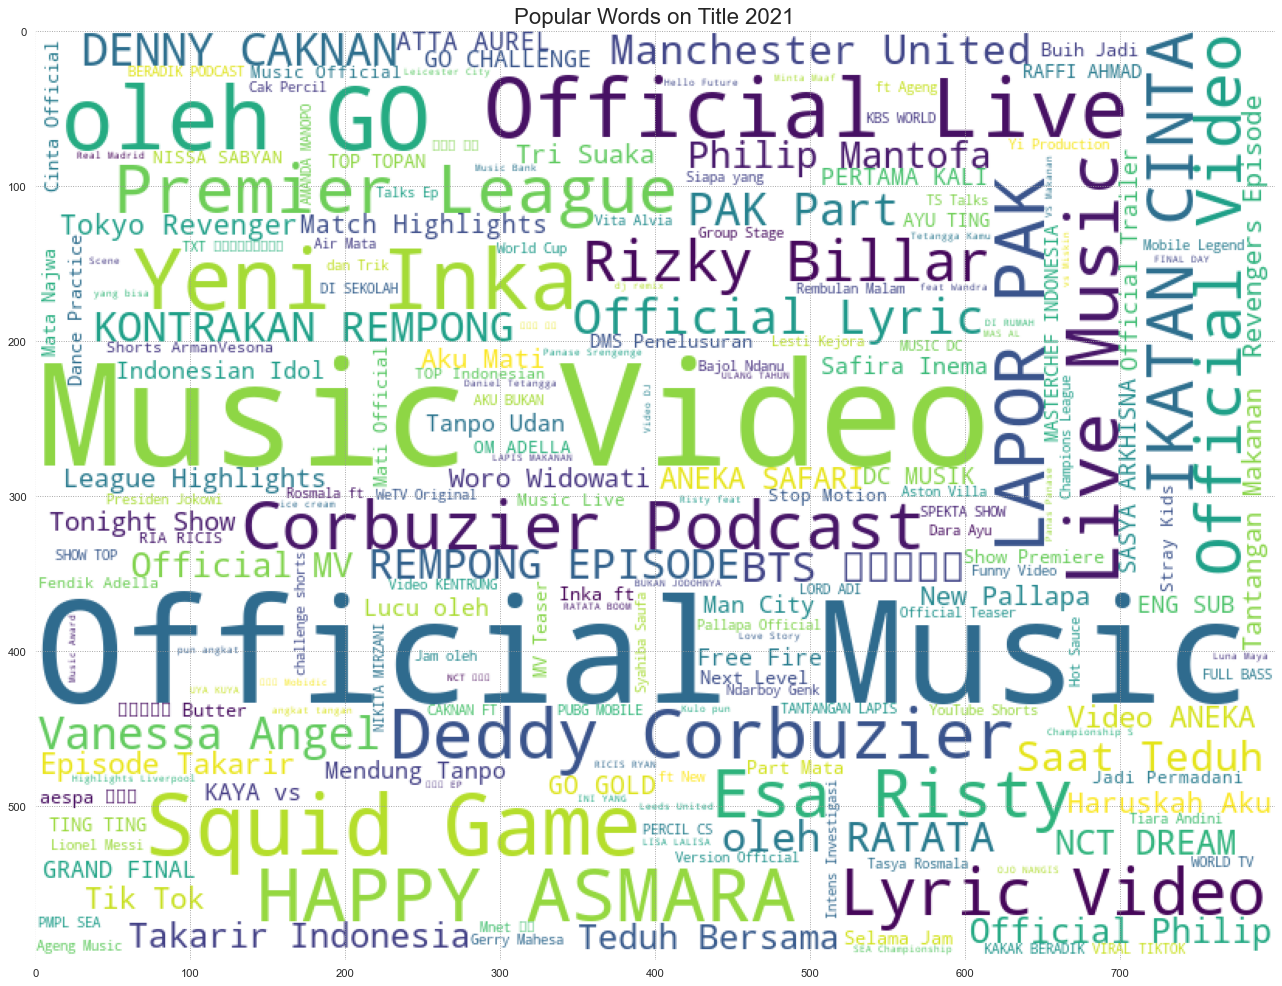

In [ ]:
plt.figure(figsize=(20,16), dpi=80)

yt_ina_2021_title = []
for i in yt_ina_2021['title']:
    for j in str(i).split(' '):
        if ''.join(filter(str.isalpha, j)) != '':
            yt_ina_2021_title.append(''.join(filter(str.isalpha, j)))
wc2021_title = WordCloud(background_color='white', width=800, height=600).generate(' '.join(yt_ina_2021_title))
plt.title('Popular Words on Title 2021', fontsize=20)
plt.imshow(wc2021_title)

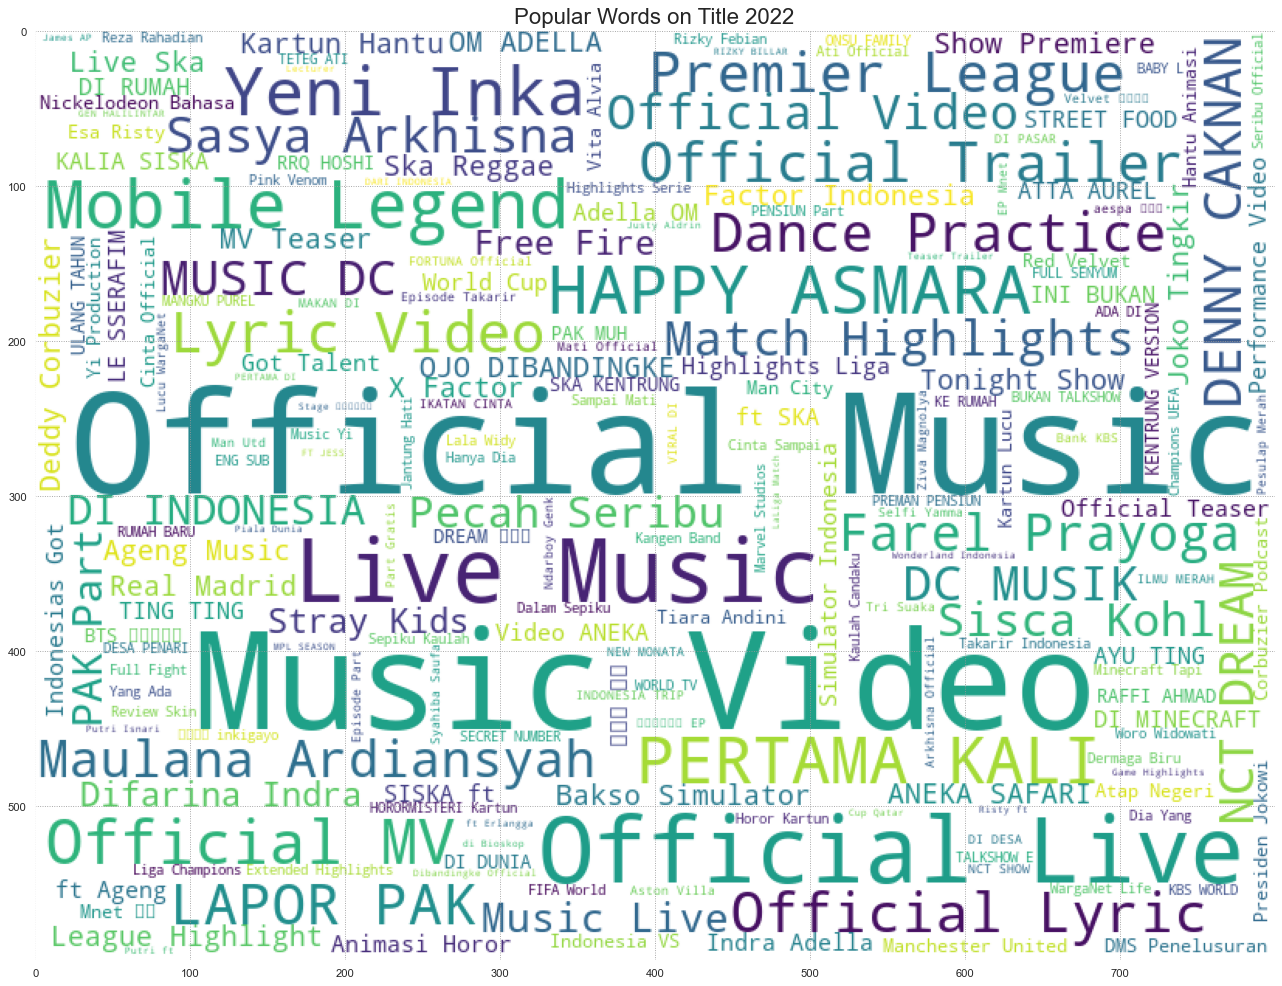

In [ ]:
plt.figure(figsize=(20,16), dpi=80)

yt_ina_2022_title = []
for i in yt_ina_2022['title']:
    for j in str(i).split(' '):
        if ''.join(filter(str.isalpha, j)) != '':
            yt_ina_2022_title.append(''.join(filter(str.isalpha, j)))
wc2022_title = WordCloud(background_color='white', width=800, height=600).generate(' '.join(yt_ina_2022_title))
plt.title('Popular Words on Title 2022', fontsize=20)
plt.imshow(wc2022_title)

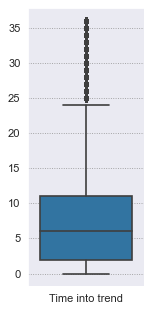

In [ ]:
plt.figure(figsize=(2,4), dpi=80)
yt_ina_timeintotrend = pd.DataFrame((yt_ina['trending_time'] - yt_ina['publish_time']).dt.days)
yt_ina_timeintotrend.columns = ['Time into trend']
sns.boxplot(data = yt_ina_timeintotrend)
plt.tight_layout()
plt.show()

In [ ]:
allowed_region = []
for i in yt_ina[yt_ina.allowed_region.notna()]['allowed_region']:
    for j in i[1:-1].split(', '):
        allowed_region.append(j.strip("'"))
list(set(allowed_region))
loc = pd.Series(allowed_region).value_counts()
location = pd.DataFrame({'Country_id':loc.index, 'Videos':loc.values})
location['Country'] = location.Country_id.apply(lambda x: country_name_to_country_alpha3(country_alpha2_to_country_name(x)))
location['Country_name'] = location.Country_id.apply(lambda x: country_alpha2_to_country_name(x))
location['Videos_scale'] = np.log10(location.Videos)

allowed = px.choropleth(data_frame=location,
                        locations='Country',
                        locationmode='ISO-3',
                        scope='world',
                        color='Videos_scale',
                        hover_name='Country_name',
                        hover_data=['Videos'],
                        title='Allowed Region')
allowed.update_geos(fitbounds="locations", visible=False)
iplot(allowed)

In [ ]:
blocked_region = []
for i in yt_ina[yt_ina.blocked_region.notna()]['blocked_region']:
    for j in i[1:-1].split(', '):
        blocked_region.append(j.strip("'"))
list(set(blocked_region))
loc = pd.Series(blocked_region).value_counts()
location = pd.DataFrame({'Country_id':loc.index, 'Videos':loc.values})
location['Country'] = location.Country_id.apply(lambda x: country_name_to_country_alpha3(country_alpha2_to_country_name(x)))
location['Country_name'] = location.Country_id.apply(lambda x: country_alpha2_to_country_name(x))
location['Videos_scale'] = np.log10(location.Videos)

blocked = px.choropleth(data_frame=location,
                        locations='Country',
                        locationmode='ISO-3',
                        scope='world',
                        color='Videos_scale',
                        hover_name='Country_name',
                        hover_data=['Videos'], 
                        color_continuous_scale=px.colors.diverging.Spectral_r,
                        title='Blocked Region')
blocked.update_geos(fitbounds="locations", visible=False)
iplot(blocked)

In [25]:
yt_ina.to_excel('C:\\Users\\HP G7\\Desktop\\IMPORTANT!!!\\KuliahNew\\Side Quest\\Latihan Program\\Personal\\Personal Project\\DSProjects\\Youtube\\Output\\yt_ina.xlsx')
yt_ina_2021.to_excel('C:\\Users\\HP G7\\Desktop\\IMPORTANT!!!\\KuliahNew\\Side Quest\\Latihan Program\\Personal\\Personal Project\\DSProjects\\Youtube\\Output\\yt_ina_2021.xlsx')
yt_ina_2022.to_excel('C:\\Users\\HP G7\\Desktop\\IMPORTANT!!!\\KuliahNew\\Side Quest\\Latihan Program\\Personal\\Personal Project\\DSProjects\\Youtube\\Output\\yt_ina_2022.xlsx')
yt_ina_trend_monthstat.to_excel('C:\\Users\\HP G7\\Desktop\\IMPORTANT!!!\\KuliahNew\\Side Quest\\Latihan Program\\Personal\\Personal Project\\DSProjects\\Youtube\\Output\\yt_ina_trend.xlsx')
yt_ina_published_monthstat.to_excel('C:\\Users\\HP G7\\Desktop\\IMPORTANT!!!\\KuliahNew\\Side Quest\\Latihan Program\\Personal\\Personal Project\\DSProjects\\Youtube\\Output\\yt_ina_published.xlsx')
yt_ina_attention.to_excel('C:\\Users\\HP G7\\Desktop\\IMPORTANT!!!\\KuliahNew\\Side Quest\\Latihan Program\\Personal\\Personal Project\\DSProjects\\Youtube\\Output\\yt_ina_attention.xlsx')
yt_ina_channel_2021.to_excel('C:\\Users\\HP G7\\Desktop\\IMPORTANT!!!\\KuliahNew\\Side Quest\\Latihan Program\\Personal\\Personal Project\\DSProjects\\Youtube\\Output\\yt_ina_channel_2021.xlsx')
yt_ina_channel_2022.to_excel('C:\\Users\\HP G7\\Desktop\\IMPORTANT!!!\\KuliahNew\\Side Quest\\Latihan Program\\Personal\\Personal Project\\DSProjects\\Youtube\\Output\\yt_ina_channel_2022.xlsx')
yt_ina_category_2021.to_excel('C:\\Users\\HP G7\\Desktop\\IMPORTANT!!!\\KuliahNew\\Side Quest\\Latihan Program\\Personal\\Personal Project\\DSProjects\\Youtube\\Output\\yt_ina_category_2021.xlsx')
yt_ina_category_2022.to_excel('C:\\Users\\HP G7\\Desktop\\IMPORTANT!!!\\KuliahNew\\Side Quest\\Latihan Program\\Personal\\Personal Project\\DSProjects\\Youtube\\Output\\yt_ina_category_2022.xlsx')

ValueError: Excel does not support datetimes with timezones. Please ensure that datetimes are timezone unaware before writing to Excel.